# Kaggle - Airbus Ship Detection Challenge

We chose a Kaggle challenge as our project.

## Description
<i>Airbus is excited to challenge Kagglers to build a model that detects all ships in satellite images as quickly as possible. Can you find them even in imagery with clouds or haze?

Here’s the backstory: Shipping traffic is growing fast. More ships increase the chances of infractions at sea like environmentally devastating ship accidents, piracy, illegal fishing, drug trafficking, and illegal cargo movement. This has compelled many organizations, from environmental protection agencies to insurance companies and national government authorities, to have a closer watch over the open seas.

Airbus offers comprehensive maritime monitoring services by building a meaningful solution for wide coverage, fine details, intensive monitoring, premium reactivity and interpretation response. Combining its proprietary-data with highly-trained analysts, they help to support the maritime industry to increase knowledge, anticipate threats, trigger alerts, and improve efficiency at sea.

A lot of work has been done over the last 10 years to automatically extract objects from satellite images with significative results but no effective operational effects. Now Airbus is turning to Kagglers to increase the accuracy and speed of automatic ship detection.</i> [Source](https://www.kaggle.com/c/airbus-ship-detection#description)

## Dataset
Kaggle provided us with the datasets for training, validation and testing. The images are 768 by 768 pixels, and separated into two folders. The train folder contains about 104 000 images and test folder 88 500. We are planning to rotate and mirror the train images and thereby increasing its size 16 times. We will most likely use cross validation (k-fold probably)

### The first approach was to detect sharp variations in the image that would indicate the presence of ships. We calculated the standard deviation and then plotted the results for each image.

### Code to visualize data

In [1]:
#Define the location of the images
LOCATION = 'train/'

In [2]:
#import libraries
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image, ImageDraw
import csv
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

def show_images(CSV):
    with open(CSV, 'r') as f: #Load data from CSV
        reader = csv.reader(f)
        samples = list(reader)
        samples = samples[1:]
        f.close()

    images = [];
    ships = [];
    #File format (This is the original format we got from Kaggle):
    #Example: "0570217ba.jpg,555509 4 556273 8 557041 9 557809 4"
    #The first element is the filename
    #The second one contains pair of numbers in a sequence the first one is the starting pixel (the top left corner is 1)
    #than going down and right
    #Second number is the run length from the starting position
    #There is at least one line for every image, with empty second value for shipless images
    #And each line is represent only one ship therefor it contains multiple line for images containing multiple ships
    
    
    filename = samples[0][0];
    for sample in samples: #iterate through the lines on CSV file
        #We want to join together lines that associates with the same image,
        #so we only run this code when reaching a new image
        if(filename != sample[0]):
            ships = np.array(ships).reshape(int(len(ships)/2),2) #separate pair of numbers
            images.append([filename, ships]) #save data into iamges
            ships = [] #reset
            filename = sample[0] #update filename
        ships += map(int, sample[1].split()) #Join data and convert to integer
    ships = np.array(ships).reshape(int(len(ships)/2),2)
    images.append([filename, ships])

    #Display images
    for image in images:
        filename = image[0]
        ship = image[1]

        im = Image.open(LOCATION + filename)
        plt.rcParams["figure.figsize"] = [16,16] #Increase the size
        fig, ax = plt.subplots(ncols=2, nrows=1)
        ax[0].imshow(np.asarray(im)) #Left image is the original

        #Draw red rectangulars over the ships
        draw = ImageDraw.Draw(im)
        for line in ship:
            l = [line[0] // 768, line[0] % 768, line[0] // 768, (line[0] % 768) + line[1]] #Convert into coordiantes
            draw.line(l, fill=(255,0,0))

        ax[1].imshow(np.asarray(im)) #display the image and the red rectangulars

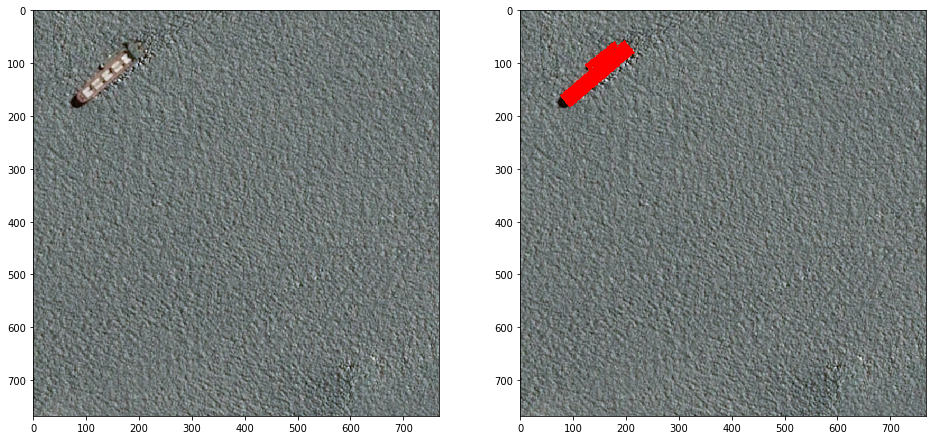

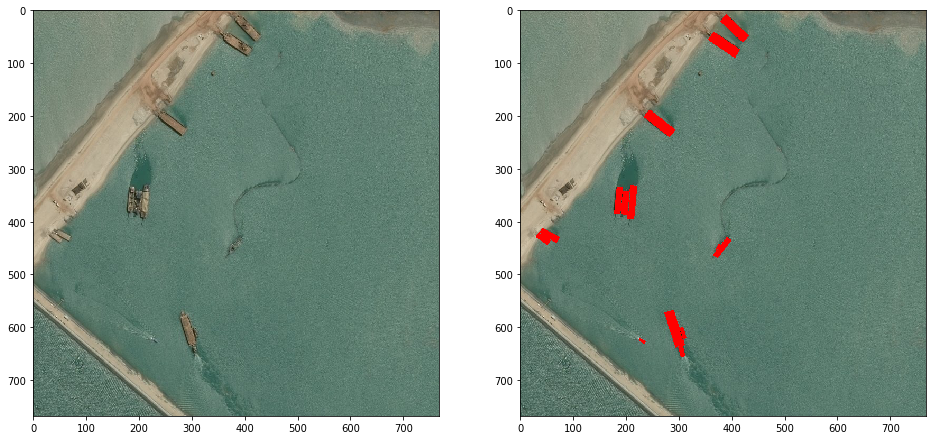

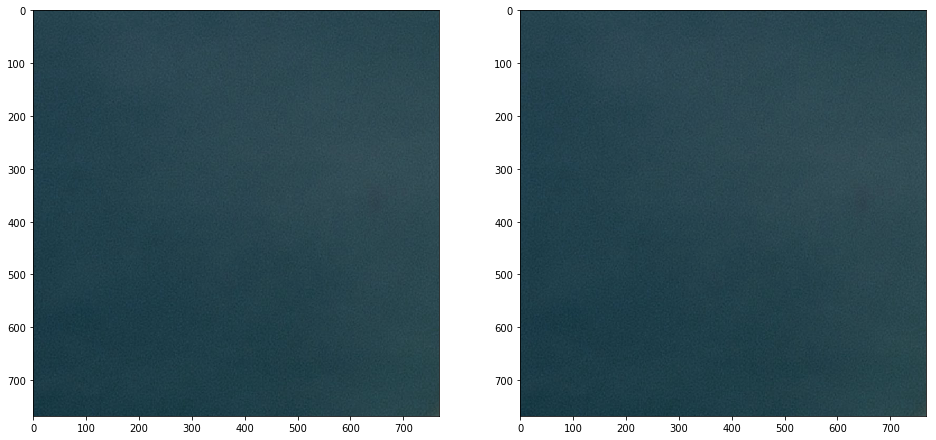

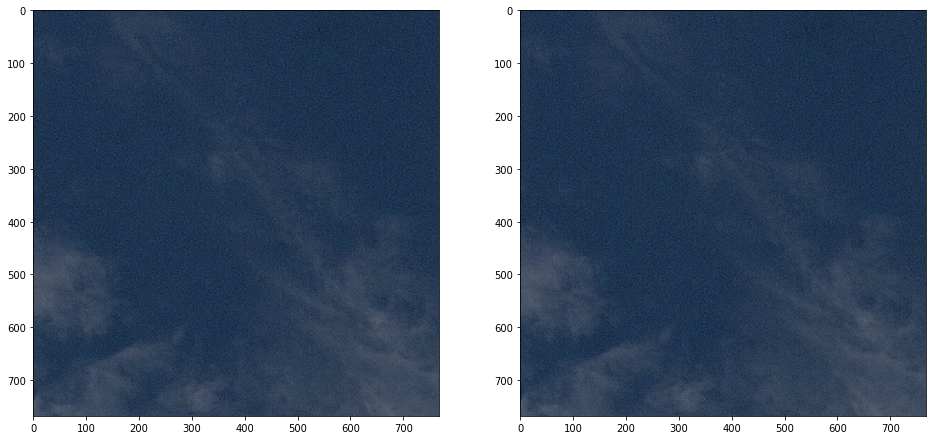

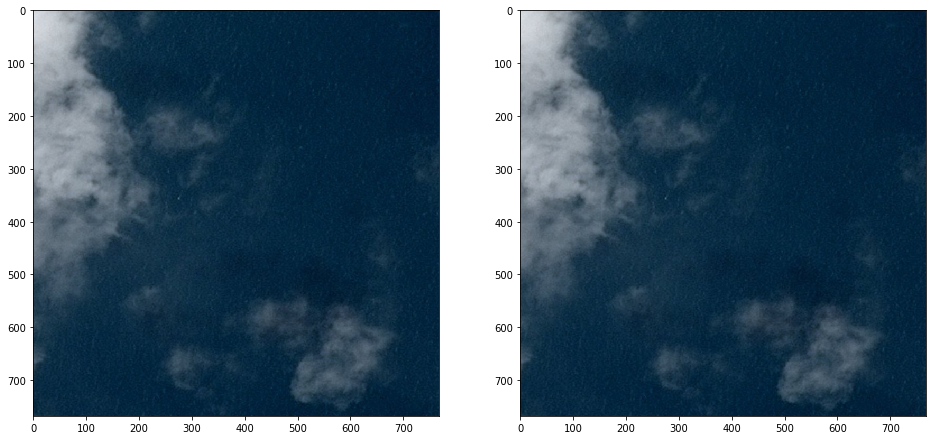

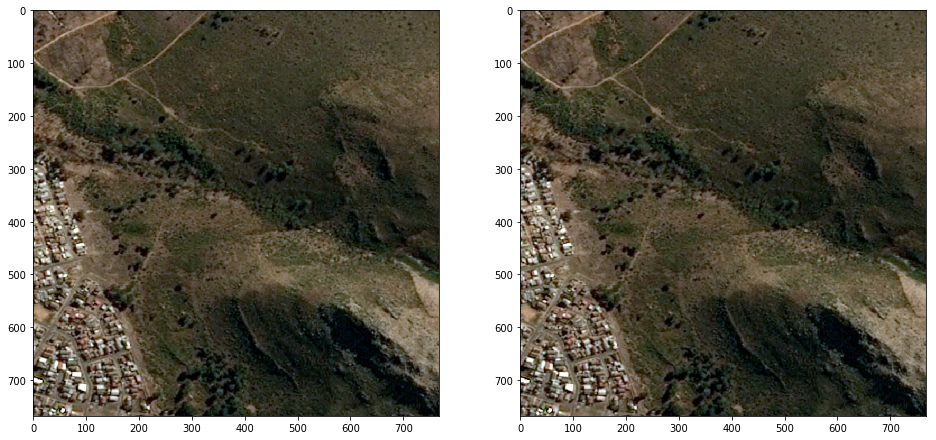

In [3]:
show_images('demo0.csv')

### Preprocessing
Looking into the images we quickly realised that only a small porcion of them contains ships (circa 15%) and most of them are just blue empty sea (mostly very homogen). We could find images about terrain without any water surface but the amount of these image is neglectable. We decided to filter out the images that contains homogen water surface. Initially we tried to distinguish those based on the standard deviation of the pixel matrix. For noise cancellation purpose we calculated the mean and standard deviation on blocks of pixels. (2 by 2, 4 bu 4, 16 by 16 pixels, etc.)

In [4]:
from PIL import Image
import numpy as np
from IPython.display import Image as IPImage
import math
from skimage import io, color
import csv
import matplotlib.pyplot as plt

IMGSIZE = 768

with open('samples.csv', 'r') as f:
    reader = csv.reader(f)
    samples = list(reader)
    samples = samples[1:]

block = 192  #number of blocks along an axis
offset = IMGSIZE/block

#We will collect in arrays the data (Separatly for images that contains ships and those which not)
lum_std = [np.zeros(0), np.zeros(0)] #standard deviation of luminescence values
lim_coef = [np.zeros(0), np.zeros(0)]

for file in samples:
    #file: ['00003e153.jpg', '1']
    # 1 -> no ship on the image
    # 0 -> there is at least one ship on the image
    filename = file[0]
    sea = int(file[1])
    title = ["contains ship", "NOT contains ship"]
    print("Filename: %s -- %s" % (filename, title[sea]))

    rgb = io.imread(LOCATION + filename) #Load the RGB channels
    
    lab = color.rgb2lab(rgb) #We used a LAB color space witch is closer to human vision than RGB 
    
    #export color matrixes into separate numpy arrays
    l, a, b = np.array(lab[:,:,0]).reshape(IMGSIZE,IMGSIZE), np.array(lab[:,:,1]).reshape(IMGSIZE,IMGSIZE), np.array(lab[:,:,2]).reshape(IMGSIZE,IMGSIZE)
    
    ##calculate the standard deviation
    std=[np.std(l), np.std(a), np.std(b)]
    print("Standard deviation: %.2f, A: %.2f, B:%.2f" % (std[0], std[1], std[2]))
    
    #Standard deviation of luminscence
    lum_std[sea] = np.append(lum_std[sea],std[0])
    
    #arrays for block mean values
    l_sub = np.zeros(block*block).reshape(block,block)
    a_sub = np.zeros(block*block).reshape(block,block)
    b_sub = np.zeros(block*block).reshape(block,block)

    if(block != IMGSIZE):
        for x in range(0,block):
            for y in range(0,block):
                for i in range(0,3):
                    (l_sub, a_sub, b_sub)[i][x,y] = np.average((l, a, b)[i][x:int(x+offset),y:int(y+offset)]) #calculate mean value of each block
    else:
        l_sub, a_sub, b_sub = l, a, b

    #calculate some statistical values
    avg = np.average(l_sub)
    std = np.std(l_sub)
    data_min = np.min(l_sub)
    data_max = np.max(l_sub)
    
    print("Standard deviation of sub luminescence: %.2f, min: %.2f, max: %.2f" % (std, data_min, data_max))
    
    z = max(avg-data_min, data_max - avg)*block/std #calculate limit coefficient
    lim_coef[sea] = np.append(lim_coef[sea],z)
    
    print("-----------------------------------------------------------")

Filename: 00003e153.jpg -- NOT contains ship
Standard deviation: 2.69, A: 1.01, B:1.46
Standard deviation of sub luminescence: 1.73, min: 14.53, max: 28.54
-----------------------------------------------------------
Filename: 000155de5.jpg -- contains ship
Standard deviation: 3.16, A: 0.77, B:0.83
Standard deviation of sub luminescence: 1.84, min: 28.89, max: 44.93
-----------------------------------------------------------
Filename: 00021ddc3.jpg -- contains ship
Standard deviation: 14.21, A: 4.97, B:4.39
Standard deviation of sub luminescence: 10.66, min: 15.95, max: 87.78
-----------------------------------------------------------
Filename: 0002756f7.jpg -- contains ship
Standard deviation: 6.09, A: 0.96, B:0.89
Standard deviation of sub luminescence: 1.97, min: 33.66, max: 52.56
-----------------------------------------------------------
Filename: 0002d0f32.jpg -- NOT contains ship
Standard deviation: 22.60, A: 1.51, B:3.85
Standard deviation of sub luminescence: 1.93, min: 0.35, m

Standard deviation: 2.94, A: 0.88, B:0.90
Standard deviation of sub luminescence: 3.20, min: 20.54, max: 44.03
-----------------------------------------------------------
Filename: 0016c1d02.jpg -- NOT contains ship
Standard deviation: 0.82, A: 0.92, B:1.02
Standard deviation of sub luminescence: 0.48, min: 1.57, max: 6.78
-----------------------------------------------------------
Filename: 001739657.jpg -- NOT contains ship
Standard deviation: 2.51, A: 0.58, B:0.66
Standard deviation of sub luminescence: 1.59, min: 15.94, max: 28.85
-----------------------------------------------------------
Filename: 001883b1b.jpg -- NOT contains ship
Standard deviation: 5.18, A: 1.95, B:2.64
Standard deviation of sub luminescence: 4.07, min: 7.20, max: 31.15
-----------------------------------------------------------
Filename: 0019880c1.jpg -- NOT contains ship
Standard deviation: 3.66, A: 0.77, B:1.29
Standard deviation of sub luminescence: 2.30, min: 19.78, max: 38.41
----------------------------

Standard deviation: 1.13, A: 0.87, B:0.93
Standard deviation of sub luminescence: 0.61, min: 15.01, max: 19.61
-----------------------------------------------------------
Filename: 002fdcf51.jpg -- contains ship
Standard deviation: 4.84, A: 1.52, B:2.08
Standard deviation of sub luminescence: 2.09, min: 23.05, max: 41.95
-----------------------------------------------------------
Filename: 002febce2.jpg -- NOT contains ship
Standard deviation: 4.83, A: 1.61, B:2.19
Standard deviation of sub luminescence: 3.77, min: 4.11, max: 56.99
-----------------------------------------------------------
Filename: 003080f2f.jpg -- NOT contains ship
Standard deviation: 1.85, A: 1.16, B:1.05
Standard deviation of sub luminescence: 1.10, min: 5.02, max: 15.00
-----------------------------------------------------------
Filename: 00319c32d.jpg -- contains ship
Standard deviation: 1.66, A: 0.68, B:0.67
Standard deviation of sub luminescence: 0.72, min: 25.03, max: 29.78
-----------------------------------

Text(0,0.5,'image count')

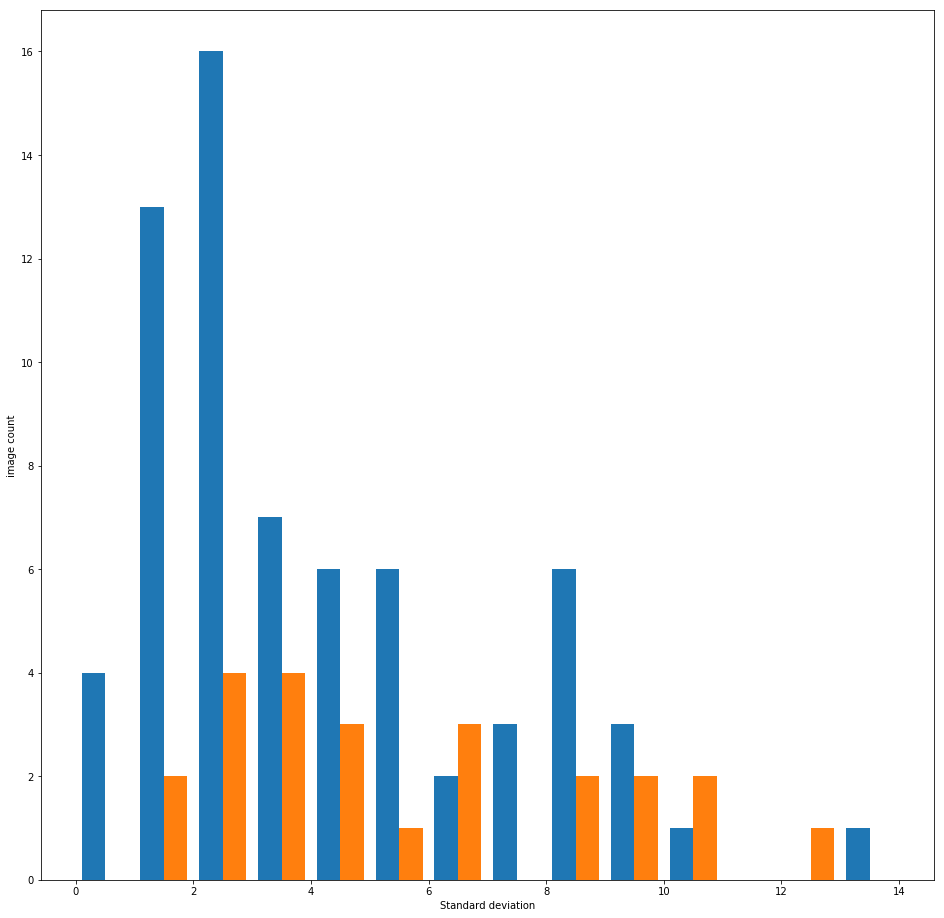

In [5]:
plt.hist((lum_std[1], lum_std[0]), range(0,15)) #create histogram
plt.xlabel("Standard deviation")
plt.ylabel("image count")

Looking at the diagram we may discard images with low standard deviation. For loop that counts images (separately for images containing ships and images without ships) with standard deviation lower than 2

In [6]:
sea = 0
ship = 0

threshold = 2 #we count images below this threshold value
for i in lum_std[0]:
    if(i < threshold):
        ship = ship + 1
for i in lum_std[1]:
    if(i < threshold):
        sea = sea + 1
print("ship: %.3f, sea: %.3f" %(float(ship)/lum_std[0].size, float(sea)/lum_std[1].size))

ship: 0.080, sea: 0.227


Although the portion of images with ships is lower than images without, the ratio between the two numbers is too small.

Text(0,0.5,'image count')

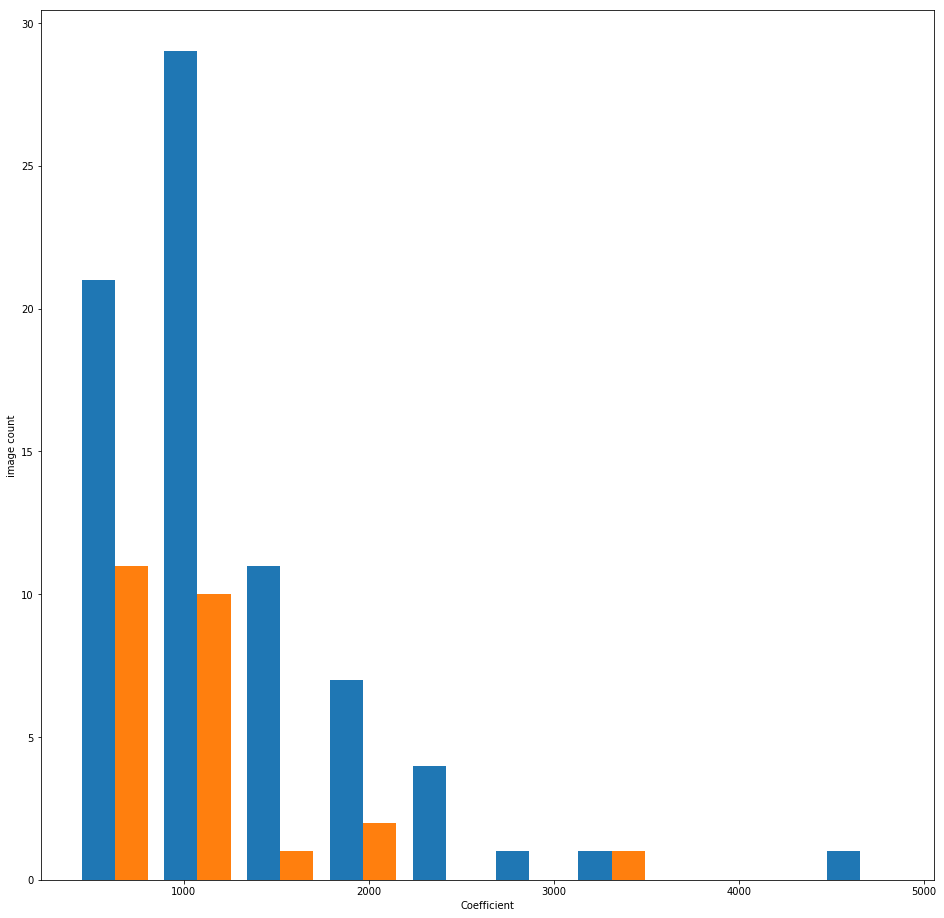

In [7]:
plt.hist((lim_coef[1], lim_coef[0])) #create histogram
plt.xlabel("Coefficient")
plt.ylabel("image count")

Doing the same calculation with threshold = 650

In [8]:
sea = 0
ship = 0

threshold = 650 #we count images below this threshold value
for i in lim_coef[0]:
    if(i < threshold):
        ship = ship + 1
for i in lim_coef[1]:
    if(i < threshold):
        sea = sea + 1
print("ship: %.3f, sea: %.3f" %(float(ship)/lim_coef[0].size, float(sea)/lim_coef[1].size))

ship: 0.040, sea: 0.080


But this didn't gave us a satisfying result. Since most of the time the ships are the most dark or bright objects on the image, we tried to use that with the folowing code.

In [9]:
#import libraries
from PIL import Image
import numpy as np
import math
from skimage import io, color
import csv
import matplotlib.pyplot as plt
from scipy.ndimage.morphology import binary_erosion
from scipy.ndimage.measurements import find_objects, label
import threading

PRINT_FREQUENCY = 100 #printout frequency (later described)


def detect_object_and_color(FILEPATH, EROSION = 1, THRESHOLD_UP = .01, THRESHOLD_DOWN = .01):
    IMGSIZE = 768 #The images are 768 by 768 pixels
    ia = np.ndarray([IMGSIZE,IMGSIZE])
    img = plt.imread(FILEPATH)
    lum = color.rgb2lab(img) #We used a LAB color space witch is closer to human vision than RGB 
    #lum: luminescent
    ia = lum[:,:, 0]
    thr_low = np.sort(ia.flat)[int(IMGSIZE*IMGSIZE*THRESHOLD_DOWN)] #lower limit 
    thr_high = np.sort(ia.flat)[int(IMGSIZE*IMGSIZE*(1-THRESHOLD_UP))] #upper limit
    for x in range(IMGSIZE):
        for y in range(IMGSIZE):
            #check if given pixel is below the lower or higher the upper limit
            ia[x, y] = 1 if ia[x, y] < thr_low else 1 if ia[x, y] > thr_high else 0
            #Now we have a matrix with value 1 where pixel is below lower limit or over upper limit. 0 othervise.
            #The folowing few manipulations are performed on this ia.
    ia = binary_erosion(input=ia, iterations=EROSION) #we used binary erosion to supress random noise
    ia = ia.astype(int)
    ia, _ = label(ia)
    #scipy.ndimage.measurements.find_objects used for finding the larger objects (for example: ships)
    objs = find_objects(ia)
    max_size = -1
    for o in range(len(objs)):
        obj = ia[objs[o]]
        size = sum((obj != 0).flat)
        max_size = max(size, max_size) #select the size of the largest object
    #return the max_size along the LAB colorspace's mean values
    return (max_size, np.mean(lum[0]), np.mean(lum[1]), np.mean(lum[2])) 

#This function will iterate through the images and call the previous function
def iterate_images(LOG, samples, EROSION = 5, THRESHOLD_UP = .01, THRESHOLD_DOWN = .01):
     #We will collect in this array the max_size values. (Separatly for images that contains ships and those which not)
    max_object_sizes = [np.zeros(0), np.zeros(0)]
    length = len(samples)
    for idx, file in enumerate(samples):
        #file: ['00003e153.jpg', '1']
        # 1 -> no ship on the image
        # 0 -> there is at least one ship on the image
        filename = file[0]
        sea = int(file[1])
        obj = detect_object_and_color(LOCATION + filename, EROSION, THRESHOLD_UP, THRESHOLD_DOWN)[0]
        max_object_sizes[sea] = np.append(max_object_sizes[sea], obj)
        if((idx+1)%PRINT_FREQUENCY == 0 or idx + 1 == length): #save the result in a CSV file after PRINT_FREQUENCY (500) images
            current = max_object_sizes[0].size + max_object_sizes[1].size
            for threshold in range(-1, 20): #Define a threshold level for max_size
                count_ship = 0
                count_sea = 0
                for e in max_object_sizes[0]: #Iterate through the ship array
                    if e <= threshold:
                        count_ship = count_ship + 1 #Increment the counter
                for e in max_object_sizes[1]: #Iterate through the non ship array
                    if e <= threshold:
                        count_sea = count_sea + 1
                #calculate the proportion of count_ship to the number of all images with ship in the sample
                ship = 0 if max_object_sizes[0].size == 0 else float(count_ship)/max_object_sizes[0].size 
                sea  = 0 if max_object_sizes[1].size == 0 else float(count_sea)/max_object_sizes[1].size
                with open(LOG, 'a') as csvfile: #save values
                    logger = csv.writer(csvfile, delimiter=',',
                                quotechar='|', quoting=csv.QUOTE_MINIMAL)
                    logger.writerow([current, length, EROSION, THRESHOLD_UP, THRESHOLD_DOWN, threshold, ship, sea])
                    csvfile.close()

We used LibreOffice Calc to generate the CSV file from the original CSV, but it can be easily done with python.
1. We dropped all the lines from the table with index over 15000
2. A transformed the ship position into a bool variable (depending on wheather it was present in the file)
3. We discarded every duplicate line
4. Saved the file

In [10]:
with open('samples.csv', 'r') as f: #Open file
    reader = csv.reader(f)
    samples = list(reader)
    samples = samples[1:]
    f.close()

We ran 1000 samples with every combination of this 3 parameters and than we discarded those with didn't give promising result

In [11]:
EROSION = [2, 3, 1]
THRESHOLD_UP = [.001, .002, .005, .01, .02, .05, .1]
THRESHOLD_DOWN = [.001, .002, .005, .01, .02, .05, .1]

Therefor we left with these parameters and we used 13 000 samples to find the best paramters

In [12]:
EROSION = [1, 2]
THRESHOLD_UP = [.005, .01, .02]
THRESHOLD_DOWN = [.005, .01, .02]

We used LibreOffice Calc to interpret the results (in both cases):
1. Discard all lines exept the most recent one
2. Discard all lines with grater than 3% loss of the ships
3. Order the table descending based on sea

| EROSION | THRESHOLD_UP | THRESHOLD_DOWN | threshold |      ship      |      sea      |
| ------- | ------------ | -------------- | --------- | -------------- | ------------- |
|    1    |    0.005   	 |      0.01	  |     15    |	  0.029925187  |  0.3184964328 |
|    1    |    0.01   	 |      0.01	  |     19    |	  0.0293710169 |  0.3118943669 |
|    1    |    0.005   	 |      0.01	  |     14    |	  0.0285397617 |  0.3036950272 |
|    1    |    0.01   	 |      0.01	  |     18    |	  0.0271543364 |  0.2982642956 |
|    1    |    0.01   	 |      0.005	  |     16    |	  0.029648102  |  0.2980513257 |

(Where threshold is the selected max_size limit value)  
<b>With this technique we are able to discard ~31% of the images that doesn't contain a ship and only loseing 3% of the images that contains ship.</b>

In [13]:
if False: #this takes too much time
    #Iterates through all 3 paramters
    for erosion in EROSION:
        for thr_up in THRESHOLD_UP:
            for thr_down in THRESHOLD_DOWN:
                iterate_images('log.csv', samples, erosion, thr_up, thr_down)    

However this technique has some limitations. When an image is mostly homogen sea and only containing a small ship it will classify it as a sea only image. Some examples of that:

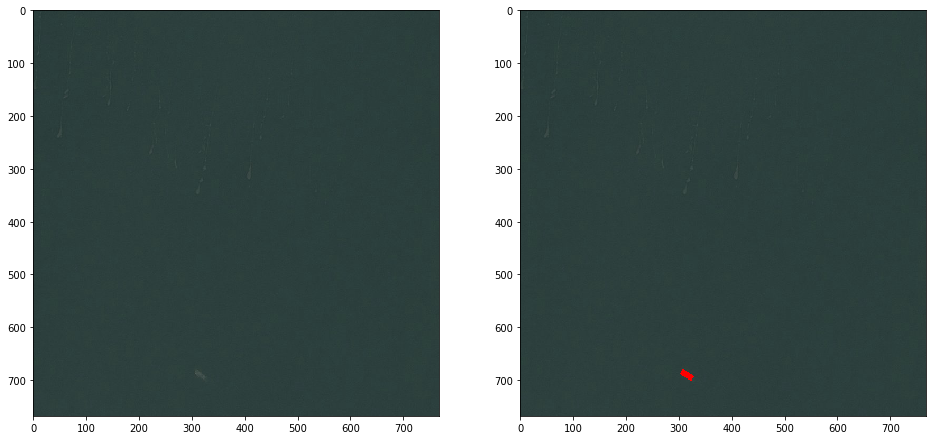

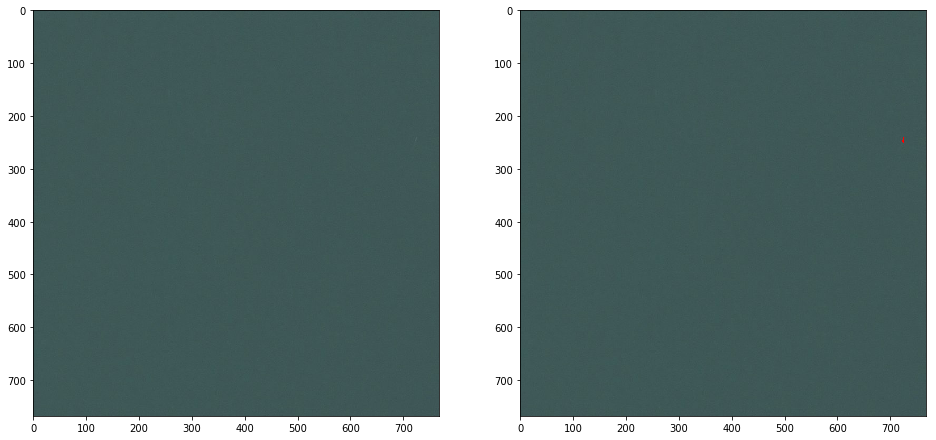

In [14]:
show_images('demo1.csv')

### Next, we decided to filter out image containing no ships based on color.

In this section, we try to remove images of open water or land, that do not contain any ships. The outline of this approach:

* Calculating the mean color in RGB color space.
* Calculating the mean color in Lab color space.
* Using k-means clustering to identify the dominant colors.
* Using thresholding and binary erosion to find the largest objects with mostly black or white features.
* Visualizing the results.
* Using a fully connected neural network to use these results and make predictions.

We did a manual categorization of 2000 images: **land**, **water** or **mixed** (having both land and water). **Land** (2%) contains no ships. **Mixed** (8%) images have nearly a 50% chance to contain ships. **Water** (90%) images have around 12% chance to contain ships. Around only 14% of the images contain any ships. A total of 100 images (33% from each category) are used later for analysis.

This program takes a very long time to run (depending on the length of the dataset), therefore the code was already ran (with a reduced dataset) and the results are used for visualisation. The program will use these saved results, but the original code can also be read.

In [15]:
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from skimage import io, color
import os
%matplotlib inline
from scipy.ndimage.morphology import binary_erosion
from scipy.ndimage.measurements import find_objects, label

def imgcolor(FILENAME): #get the average color of the image in RGB and Lab color space
    rgb = io.imread(FILENAME)
    r = np.mean(rgb[:,:,0].flatten())
    g = np.mean(rgb[:,:,1].flatten())
    b = np.mean(rgb[:,:,2].flatten())
    lab = color.rgb2lab(rgb)
    l=np.mean(lab[:,:,0].flatten())
    a=np.mean(lab[:,:,1].flatten())
    b_=np.mean(lab[:,:,2].flatten())
    return [r, g, b, l, a, b_]

def dominant_color(FILENAME, CLUSTERS): #determine the most dominant color on the image
    rgb = io.imread(FILENAME)[::4,::4,] #reduce pixel count
    lab = color.rgb2lab(rgb)
    pixels = lab.reshape(int(768/4)**2, 3)
    kmeans = KMeans(n_clusters=CLUSTERS).fit(pixels)
    kmeans.cluster_centers_.reshape(1,CLUSTERS,3)
    _, counts = np.unique(kmeans.labels_, return_counts=True)
    l = list(zip(counts, kmeans.cluster_centers_))
    l.sort(reverse=True)
    return l[0][1]

def cluster_plot(FILENAME, CLUSTERS = 4): #show the most dominant colors of the image on a plot
    rgb = io.imread(FILENAME)[::4,::4,] #reduce pixel count
    lab = color.rgb2lab(rgb)
    pixels = lab.reshape(int(768/4)**2, 3)
    kmeans = KMeans(n_clusters=CLUSTERS).fit(pixels)
    kmeans.cluster_centers_.reshape(1,CLUSTERS,3)
    _, counts = np.unique(kmeans.labels_, return_counts=True)
    l=np.mean(lab[:,:,0].flatten())
    a=np.mean(lab[:,:,1].flatten())
    b=np.mean(lab[:,:,2].flatten())
    mean = color.lab2rgb([[[l,a,b]]])*255
    rgb_main = (color.lab2rgb(kmeans.cluster_centers_.reshape(1,CLUSTERS,3))*255).reshape(CLUSTERS,3)
    carr = np.ndarray((CLUSTERS,4))
    carr[:, 0:3] = rgb_main[:, 0:] / 255
    carr[:, 3] = np.ones((1,CLUSTERS))
    fig = plt.figure(figsize=(6,5))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlim((0,255))
    ax.set_ylim((0,255))
    ax.set_zlim((0,255))
    ax.scatter3D(xs=rgb_main[:,0],ys=rgb_main[:,1],zs=rgb_main[:,2], c=carr, s=counts*0.1)
    return (rgb_main, counts, mean)

Showing the dominant colors (this may take some time):

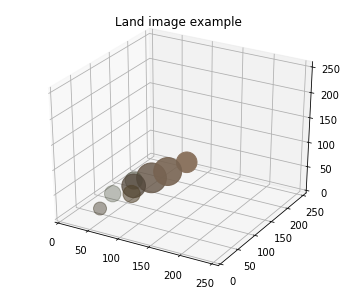

In [16]:
cluster_plot("examples/00249d8ad.jpg", CLUSTERS=8)
_ = plt.title("Land image example")

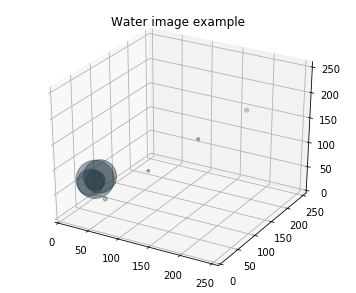

In [17]:
cluster_plot("examples/002deeb16.jpg", CLUSTERS=8)
_ = plt.title("Water image example")

This section of the code shows a promising approach to filtering. We highlight pixels if their brightness is either very low or high. Small, noisy areas are removed, and the largest remaining object has its area measured. Large areas likely indicate ships.

1491
3156
147
118


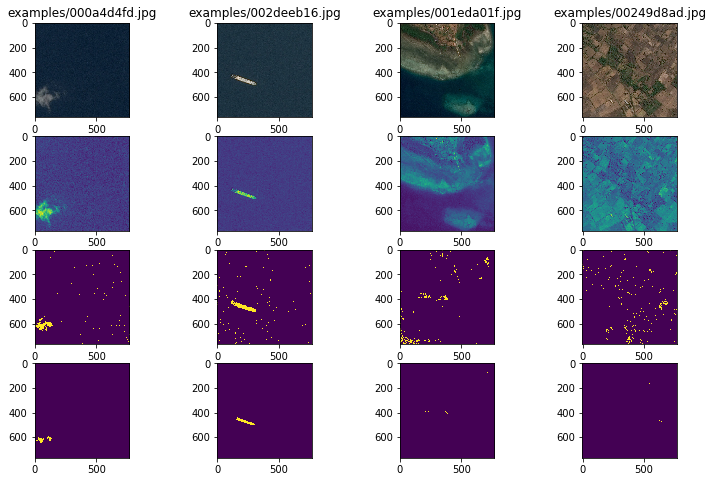

In [18]:
def detect_object(FILEPATH, EROSION = 5, THRESHOLD = .01, SIZE = 1000): #find the largest object-like feature and return its size
    IMGSIZE = 768
    ia = np.ndarray([IMGSIZE,IMGSIZE])
    img = plt.imread(FILEPATH)
    lum = color.rgb2lab(img)
    for x in range(IMGSIZE):
        for y in range(IMGSIZE):
            ia[x, y] = lum[x, y, 0]
    thr_low = np.sort(ia.flat)[int(IMGSIZE*IMGSIZE*THRESHOLD)]
    thr_high = np.sort(ia.flat)[int(IMGSIZE*IMGSIZE*(1-THRESHOLD))]
    for x in range(IMGSIZE):
        for y in range(IMGSIZE):
            ia[x, y] = 1 if ia[x, y] < thr_low else 1 if ia[x, y] > thr_high else 0
    ia = binary_erosion(input=ia, iterations=EROSION)
    ia = ia.astype(int)
    ia, _ = label(ia)
    objs = find_objects(ia)
    max_size = -1
    for o in range(len(objs)):
        obj = ia[objs[o]]
        size = sum((obj != 0).flat)
        max_size = max(size, max_size)
    return max_size
    
def detect_object_with_plots(image_names): #object detection algorithm with plots
    n = len(image_names)
    ia = np.ndarray((n,768,768))
    plt.rcParams["figure.figsize"] = [12, 8]
    fig, ax = plt.subplots(ncols=n, nrows=4)
    for i in range(len(image_names)):        
        ax[0][i].set_title(image_names[i])
        img = plt.imread(image_names[i])
        ax[0][i].imshow(img) #plot the images
        lum = color.rgb2lab(img)
        for x in range(768):
            for y in range(768):
                ia[i, x, y] = lum[x, y, 0]
        ax[1][i].imshow(ia[i]) #plot the brightness of the image
    for i in range(len(image_names)):
        thr = .01
        thr_low = np.sort(ia[i].flat)[int(768*768*thr)]
        thr_high = np.sort(ia[i].flat)[int(768*768*(1-thr))]
        for x in range(768):
            for y in range(768):
                ia[i, x, y] = 1 if ia[i, x, y] < thr_low else 1 if ia[i, x, y] > thr_high else 0
        ax[2][i].imshow(ia[i]) #plot if above or below some threshold value
    plt.subplots_adjust(wspace=.5)
    for i in range(len(image_names)):
        erosion = 5
        ia[i] = binary_erosion(input=ia[i], iterations=erosion)
        ax[3][i].imshow(ia[i]) #apply binary erosion to filter out noise

image_names=["examples/000a4d4fd.jpg", "examples/002deeb16.jpg", "examples/001eda01f.jpg", "examples/00249d8ad.jpg"]
detect_object_with_plots(image_names)
for f in image_names:
    print(detect_object(f))

In [19]:
if False: #analyse images, this takes a long time, so it is skipped
    df = pd.read_csv("manual_sorting_results_reduced.csv")
    df_empty = pd.read_csv("test_ship_segmentations.csv")
    df_empty2 = pd.read_csv("train_ship_segmentations.csv")
    df_empty = df_empty.append(df_empty2)
    df_empty = df_empty[df_empty["EncodedPixels"].isnull()]["ImageId"]
    empty = list(map(lambda x: x[:-4], list(df_empty)))
    average_color = np.array(list(map(lambda x: imgcolor("images/" + x + ".jpg"), df["file_id"])))
    dom_color = np.array(list(map(lambda x: dominant_color("images/" + x + ".jpg", 4), df["file_id"])))
    df_part = pd.DataFrame({"has_ships": list(map(lambda x: x not in empty, list(df["file_id"]))),
                            "rgb_r": average_color[:, 0],
                            "rgb_g": average_color[:, 1],
                            "rgb_b": average_color[:, 2],
                            "lab_l": average_color[:, 3],
                            "lab_a": average_color[:, 4],
                            "lab_b": average_color[:, 5],
                            "dom_l": dom_color[:, 0],
                            "dom_a": dom_color[:, 1],
                            "dom_b": dom_color[:, 2],
                           "object_size": list(map(lambda x: detect_object("images/" + x + ".jpg"), list(df["file_id"])))
                           })
    df = df.join(df_part)
    df.to_csv("output.csv")
if True: #load pre-computeed analysis data
    df = pd.read_csv("output.csv")
df

,Unnamed: 0,file_id,image_type,has_ships,rgb_r,rgb_g,rgb_b,lab_l,lab_a,lab_b,dom_l,dom_a,dom_b,object_size
0,0,00189cc36,land,False,110.196579,106.656125,89.083766,44.303881,-1.833735,10.616881,37.518476,-3.061379,9.743569,118
1,1,001f04ca3,land,False,106.758233,109.583437,94.824273,45.192004,-3.942596,8.069885,38.529353,-5.679406,9.441693,442
2,2,004514d4e,land,False,136.102898,117.132153,93.803819,50.281648,3.630089,15.627772,52.001633,4.591246,16.370874,190
3,3,0097ba701,land,False,54.830933,68.426398,55.132599,27.296690,-7.963641,6.543982,22.950036,-14.905408,5.973722,68
4,4,00b6a23c2,land,False,53.959501,75.530977,54.021413,29.491586,-13.264594,10.221612,33.942963,-14.424322,11.100446,1566
5,5,00ed5f01b,land,False,28.747009,52.590988,44.892209,19.823541,-11.433544,1.985884,19.384597,-11.507346,1.515549,28
6,6,00efe6d6c,land,False,111.395464,119.631907,111.263496,48.259479,-4.882462,3.721260,38.579479,-6.192967,4.973952,-1
7,7,010617112,land,False,67.933138,82.124880,68.871952,33.129601,-8.401182,6.236617,22.594403,-11.553256,8.175273,1468
8,8,0106f90ae,land,False,40.501248,59.539685,42.402067,22.648107,-11.329047,8.119241,28.276767,-13.835613,11.871693,2744
9,9,013ee251e,land,False,48.165861,63.254176,68.163462,24.381552,-4.314162,-5.075852,10.336925,-4.725079,-6.835437,990


In the plots below, **red** means **land**; **green** means **mixed** (land and water); **blue** means **water**. The values are marked with **X** for no ships and **O** for having ships.

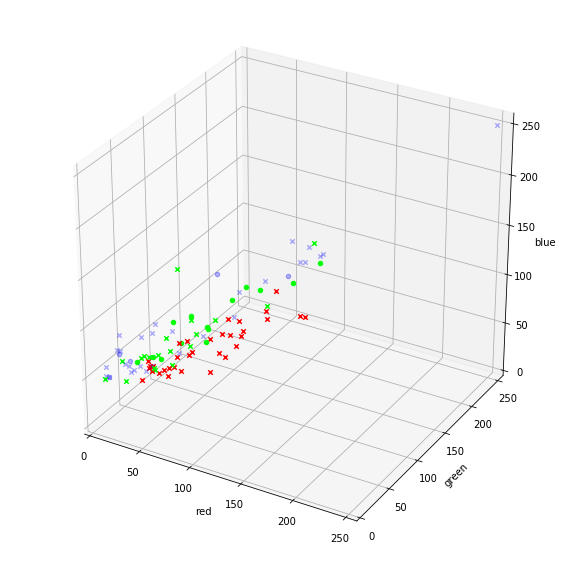

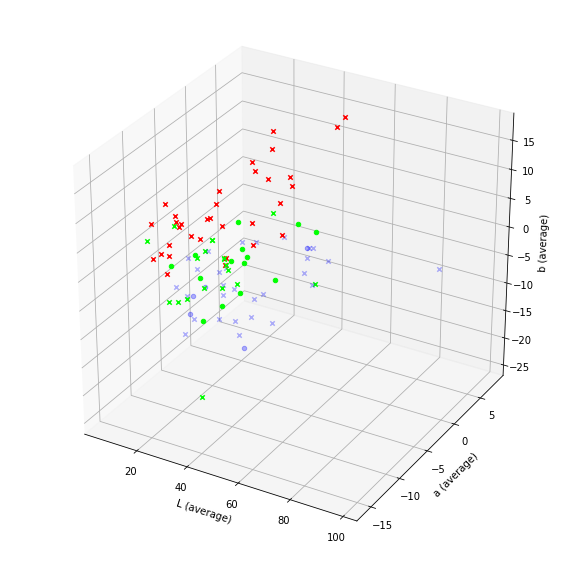

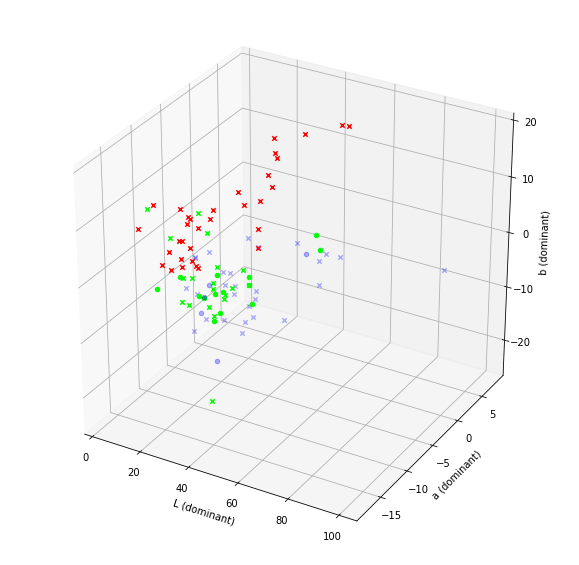

In [20]:
n = len(df)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim((0,255))
ax.set_xlabel("red")
ax.set_ylim((0,255))
ax.set_ylabel("green")
ax.set_zlim((0,255))
ax.set_zlabel("blue")
for i in range(n):
    data = df.iloc[i]
    marker = "o" if data["has_ships"] else "x"
    color = [1, 0, 0, 1] if data["image_type"] == "land" else [0, 1, 0, 1] \
                if data["image_type"] == "mixed" else [0, 0, 1, .3]
    ax.scatter(xs=data["rgb_r"], ys=data["rgb_g"], zs=data["rgb_b"], c=color, marker=marker)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel("L (average)")
ax.set_ylabel("a (average)")
ax.set_zlabel("b (average)")
for i in range(n):
    data = df.iloc[i]
    marker = "o" if data["has_ships"] else "x"
    color = [1, 0, 0, 1] if data["image_type"] == "land" else [0, 1, 0, 1] \
                if data["image_type"] == "mixed" else [0, 0, 1, .3]
    ax.scatter(xs=data["lab_l"], ys=data["lab_a"], zs=data["lab_b"], c=color, marker=marker)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel("L (dominant)")
ax.set_ylabel("a (dominant)")
ax.set_zlabel("b (dominant)")
for i in range(n):
    data = df.iloc[i]
    marker = "o" if data["has_ships"] else "x"
    color = [1, 0, 0, 1] if data["image_type"] == "land" else [0, 1, 0, 1] \
                if data["image_type"] == "mixed" else [0, 0, 1, .3]
    ax.scatter(xs=data["dom_l"], ys=data["dom_a"], zs=data["dom_b"], c=color, marker=marker)

We want to remove the most **X** (images without ships) markers without removing the **O** (images having ships) markers. It seems that converting the image to *Lab* color space, and using the *K-Means clustering* algorithm to choose the most dominant color gives the best results. This algorithm is iterative, therefore it also runs too slowly for it to be used on the entire dataset.

Using the neural network from the lecture, I created a classifier, to guess if the image is unlikely to contain ships based on the color information and the size of the largest object found.

In [21]:
#in a lot of images the object size is -1 (no big object found)
#taking the logarithm of the others may make it easier for the NN to process it
df["object_size"] = list(map(lambda f: -1 if f <= 0 else np.log(f), df["object_size"]))

from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import Callback
from keras.optimizers import SGD
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(1)
class TrainingHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.valid_losses = []
        self.accs = []
        self.valid_accs = []
        self.epoch = 0
    
    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.valid_losses.append(logs.get('val_loss'))
        self.accs.append(logs.get('acc'))
        self.valid_accs.append(logs.get('val_acc'))
        self.epoch += 1
            
history = TrainingHistory()
from keras import regularizers
model = Sequential()
model.add(Dense(10, input_shape=(4,)))
model.add(Activation("tanh"))
model.add(Dense(10, input_shape=(4,)))
model.add(Activation("tanh"))
model.add(Dense(1))
model.add(Activation("tanh"))
model.compile(loss='mean_squared_error',
              optimizer= SGD(lr=0.1, momentum=0.001, nesterov=True),
              metrics=['accuracy'])
nb_samples=len(df)
valid_split = 0.2
test_split = 0.1
samples=np.zeros(nb_samples, dtype=[('input', float, 4), ('output', float, 1)])
for i in range(nb_samples):
    samples[i] = [df["dom_l"][i], df["dom_a"][i], df["dom_b"][i], df["object_size"][i]], .5 if df["has_ships"][i] else -.5

samples_train = samples[0:int(nb_samples*(1-valid_split-test_split))]
samples_valid = samples[int(nb_samples*(1-valid_split-test_split)):int(nb_samples*(1-test_split))]
samples_test  = samples[int(nb_samples*(1-test_split)):]
    
scaler = preprocessing.StandardScaler().fit(samples_train['input'])
samples_train['input'] = scaler.transform(samples_train['input'])
samples_valid['input'] = scaler.transform(samples_valid['input'])
samples_test['input'] = scaler.transform(samples_test['input'])

from keras.callbacks import EarlyStopping
patience=30
early_stopping=EarlyStopping(patience=patience, verbose=1)

from keras.callbacks import ModelCheckpoint
checkpointer=ModelCheckpoint(filepath='weights.hdf5', save_best_only=True, verbose=1)

from keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=20, min_lr=10e-5)

from keras.callbacks import LearningRateScheduler
def scheduler(epoch):
    result=0.1
    if (epoch>20):
        result=0.05
    if (epoch>40):
        result=10e-3
    if (epoch>60):
        result=0.1
    print("Learning rate: %f" % (result))
    return result

change_lr = LearningRateScheduler(scheduler)

/home/osboxes/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [22]:
model.fit(samples_train['input'], samples_train['output'],
          batch_size=20,
          nb_epoch=2500,
          verbose=2, 
          validation_data=(samples_valid['input'],samples_valid['output']), 
          callbacks=[reduce_lr, checkpointer, early_stopping, history], 
          shuffle= True)

/home/osboxes/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  import sys


Train on 70 samples, validate on 20 samples
Epoch 1/2500
 - 0s - loss: 0.5276 - acc: 0.0000e+00 - val_loss: 0.2682 - val_acc: 0.0000e+00

Epoch 00001: val_loss improved from inf to 0.26815, saving model to weights.hdf5
Epoch 2/2500
 - 0s - loss: 0.2144 - acc: 0.0000e+00 - val_loss: 0.1782 - val_acc: 0.0000e+00

Epoch 00002: val_loss improved from 0.26815 to 0.17820, saving model to weights.hdf5
Epoch 3/2500
 - 0s - loss: 0.1752 - acc: 0.0000e+00 - val_loss: 0.2187 - val_acc: 0.0000e+00

Epoch 00003: val_loss did not improve from 0.17820
Epoch 4/2500
 - 0s - loss: 0.1528 - acc: 0.0000e+00 - val_loss: 0.2116 - val_acc: 0.0000e+00

Epoch 00004: val_loss did not improve from 0.17820
Epoch 5/2500
 - 0s - loss: 0.1432 - acc: 0.0000e+00 - val_loss: 0.1347 - val_acc: 0.0000e+00

Epoch 00005: val_loss improved from 0.17820 to 0.13472, saving model to weights.hdf5
Epoch 6/2500
 - 0s - loss: 0.1444 - acc: 0.0000e+00 - val_loss: 0.1725 - val_acc: 0.0000e+00

Epoch 00006: val_loss did not improve f

Make predictions: -0.5 if predicted to not contain ships, 0.5 if predicted to contain ships.
If the prediction is less than a threshold number, then the image is thrown away.
When the NN was trained with 2000 image large dataset, around 30% of the images was thrown away with only less than 2% of the ships lost.
In this notebook I used less images for the training and testing, and got a lesser 20-25% accuracy for determining if the image contains no ships.

total ships:  19
total water:  81
unclassified:  57
predict(ship), real(ship):  4
predict(ship), real(water):  9
predict(water), real(ship):  0
predict(water), real(water):  30
dataset reduced by:  30.0 %
ships lost:  0.0 %


(array([ 7., 16., 18., 16., 15.,  6.,  7.,  6.,  5.,  4.]),
 array([-0.68553817, -0.56727053, -0.44900288, -0.33073523, -0.21246759,
        -0.09419994,  0.02406771,  0.14233535,  0.260603  ,  0.37887065,
         0.49713829]),
 <a list of 10 Patch objects>)

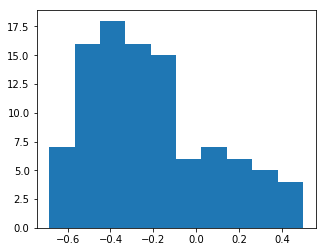

In [23]:
fig=plt.figure(figsize=(5,4))
hist_arr=model.predict(samples["input"]).ravel().astype(float)
spacing = np.linspace(0,1,20)
pred_ship_real_water = 0
pred_water_real_ship = 0
pred_ship_real_ship = 0
pred_water_real_water = 0
i = 0
total_ships = 0
for i in range(len(hist_arr)):
    real_ship = df.iloc[i]["has_ships"]
    if real_ship:
        total_ships += 1
    pred_ship = hist_arr[i] >= .2
    pred_water = hist_arr[i] < -.4
    if real_ship and pred_ship:
        pred_ship_real_ship += 1
    if real_ship and pred_water:
        pred_water_real_ship += 1
    if not real_ship and pred_water:
        pred_water_real_water += 1
    if not real_ship and pred_ship:
        pred_ship_real_water += 1
print("total ships: ", total_ships)
print("total water: ", len(hist_arr)-total_ships)
print("unclassified: ", len(hist_arr)-pred_ship_real_ship-pred_water_real_ship-pred_ship_real_water-pred_water_real_water)
print("predict(ship), real(ship): ", pred_ship_real_ship)
print("predict(ship), real(water): ", pred_ship_real_water)
print("predict(water), real(ship): ", pred_water_real_ship)
print("predict(water), real(water): ", pred_water_real_water)
print("dataset reduced by: ", (pred_water_real_ship+pred_water_real_water)/len(hist_arr)*100, "%")
print("ships lost: ", pred_water_real_ship/total_ships*100, "%")
plt.hist(hist_arr)